# Segmentation using color spaces

In [1]:
# Libraries
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import hsv_to_rgb
import numpy as np
import os
import glob
import yaml

# Scikit-image
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage import metrics

# Validation
from diceCoeff import dice
from scipy.spatial.distance import directed_hausdorff

from dictionary_manager import get_index
from dictionary_manager import get_serial_dictionary

In [8]:
def plot_images(img):
    fig, ax = plt.subplots(1, len(img), constrained_layout=True, figsize=(20,10))
    counter = 0
    for serial, image in img.items():
        ax[counter].imshow(image)
        ax[counter].set_title(serial)
        ax[counter].set_axis_off()
        counter += 1
    plt.show()

In [10]:
def colorRemoval(img, lower_1, upper_1, lower_2, upper_2):
    
    # Transforming image to HSV color space
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # lower mask
    mask0 = cv.inRange(img_hsv, lower_1, upper_1)

    # upper mask
    mask1 = cv.inRange(img_hsv, lower_2, upper_2)

    # join masks. This segments the image for the color red
    mask = mask0+mask1
    
    kernel = np.ones((3,3),np.uint8) # 5x5 kernel

    dilate = cv.dilate(mask, kernel, iterations = 10)
    
    # delete the green screen and keep the object in the image
    mask_not = cv.bitwise_not(dilate)
    
    # Remove outliers with mophological filter
    dilate = cv.dilate(mask_not, kernel, iterations = 10)
    
    result = cv.bitwise_and(img, img, mask=dilate)
       
    return result

## Segmenting the biggest element

We are going to further segment the image into the biggest area detected, then we are going to draw a bounding box of the biggest connected elements and delete the smaller ones.

In [11]:
def regionInterest(color_segmented):

    grayscale = rgb2gray(color_segmented)

    # apply threshold
    thresh = threshold_otsu(grayscale)

    bw = closing(grayscale > thresh, square(3))

    # remove artifacts connected to image border
    cleared = clear_border(bw)

    # label image regions
    label_image = label(cleared)
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=grayscale, bg_label=0)

    region = largest_area(regionprops(label_image)) # take the region with largest area

#     print('Biggest area detected: ' + str(region.area) + ' pixels')
    coords = region.coords
    # draw rectangle around segmented area
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
    
    return coords, image_label_overlay, rect

In [12]:
def largest_area(array):
    # Initialize maximum element
    max = array[0].area
    region = array[0]
  
    # Traverse array elements from second
    # and compare every element with 
    # current max
    for i in range(1, len(array)):
        if array[i].area > max:
            max = array[i].area
            region = array[i]
    return region

In [13]:
def patch_image(img_coords):    
    fig, ax = plt.subplots(1, len(img_coords), constrained_layout=True, figsize=(20,10))
    counter = 0
    for serial, items in img_coords.items():
        ax[counter].imshow(items[1])
        ax[counter].add_patch(items[2])
        ax[counter].set_title(serial)
        ax[counter].set_axis_off()
        counter += 1
    plt.show()

In [14]:
def maskObject(img, coords):
    
    mask = np.zeros(img.shape[:2], dtype = "uint8")

    for n in range(len(coords)):
        mask[coords[n][0],coords[n][1]] = 255
 
    return mask

## Smooth edges

Right now the edges are sharp and noisy, we are going to use a median filter to smooth the edges to create a clean mask for the segmentation.
We also upscale the image to perform the median filter to a higher resolution image, afterwards the image is downscaled to the original resolution. Since the median filter is outputing an grayscale image, we need to convert it back to a binary image for the mask to work.

In [15]:
def smoothEdges(mask, kernel = 15, iterations = 10):
    
    median = mask
    # Remove noise by blurring with a Median filter
    for n in range(iterations):
         median =  cv.medianBlur(median,kernel) # The kernel is the size of the filter, by default 15x15

    thresh_mask = cv.threshold(median, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    
    return thresh_mask

## Removing edges to delete point cloud outliers 

Up until this point, Dice coefficient and Hausdorff distance seem pretty good. The numbers are pretty close to the ground truth segmentation, but the masks need an additional trim along the edges, because when converting the images into point clouds, there might be outliers due to improper segmentation. So the bestway to avoid this is to remove the edges with the cv.erode() function to avoid noise when converting into point clouds.

In [16]:
def erosion(mask, iteration = 10):
    kernel = np.ones((3,3),np.uint8) # 3x3 kernel
    erosion = cv.erode(mask, kernel, iterations = iteration)
    
    return erosion

## Color range selection

We are going to pick a range of colors that fit the green from the tablecloth. We can display these color sets for the selected lower and upper bounds.

In [17]:
def color_selection():
    # lower mask (50-80)
    color_selection.lower_1_green = np.array([55,100,20])
    color_selection.upper_1_green = np.array([80,255,255])

    # upper mask (80-110)
    color_selection.lower_2_green = np.array([80,100,20])
    color_selection.upper_2_green = np.array([100,255,255])

    lower_1_square = np.full((10, 10, 3), color_selection.lower_1_green, dtype=np.uint8) / 255.0
    upper_1_square = np.full((10, 10, 3), color_selection.upper_1_green, dtype=np.uint8) / 255.0

    lower_2_square = np.full((10, 10, 3), color_selection.lower_2_green, dtype=np.uint8) / 255.0
    upper_2_square = np.full((10, 10, 3), color_selection.upper_2_green, dtype=np.uint8) / 255.0
    
    # display color selection
    fig, ax = plt.subplots(nrows=2, ncols=2)

    ax[0,0].set_title("Lower Bound")
    ax[0,0].imshow(hsv_to_rgb(lower_1_square))
    ax[0,1].imshow(hsv_to_rgb(upper_1_square))

    ax[0,1].set_title("Upper Bound")
    ax[1,0].imshow(hsv_to_rgb(lower_2_square))
    ax[1,1].imshow(hsv_to_rgb(upper_2_square))

    for a in ax.ravel():
        a.set_axis_off()

    plt.show()

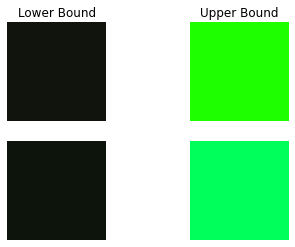

In [24]:
color_selection()

## Save the images

Then we save the images for later deprojection and create a point cloud with .ply format.

In [25]:
def segmentation(path2images):
    images = glob.glob(path2images + '/*.png')
    
    # Get the indices from the images folder corresponding to color and depth images
    colorf_index = get_index('cfondo_color', images)
    # Obtain the path of the corresponding indices for color and depth images
    colorf_files = [images[i] for i in colorf_index]
    
    
    # Get the indices from the images folder corresponding to color and depth images
    color_index = get_index('sfondo_color', images)
    # Obtain the path of the corresponding indices for color and depth images
    color_files = [images[i] for i in color_index]
    
    file_name = path2images + '/' + 'intrinsics_matrix.yaml'
    with open(file_name, 'r') as file:
        intrinsics_matrix = yaml.safe_load(file)
        
    
    serial_colorf_path = get_serial_dictionary(colorf_files, intrinsics_matrix)
    serial_color_path = get_serial_dictionary(color_files, intrinsics_matrix)
    
    imgf = {}
    for serial, path in serial_colorf_path.items():
        imgf[serial] = cv.imread(path)
        
    print('Original images')
    plot_images(imgf)    
    
    img = {}
    for serial, path in serial_color_path.items():
        img[serial] = cv.imread(path)
     
    print('No background images')
    plot_images(img)
       
    seg_color = {}
    for serial, images in img.items():
        seg_color[serial] = colorRemoval(images, color_selection.lower_1_green, color_selection.upper_1_green, color_selection.lower_2_green, color_selection.upper_2_green)
    
    print('Color segmented')
    plot_images(seg_color)
    
    coords = {}
    counter = 0
    for serial, segmented in seg_color.items():
        coords[serial] = regionInterest(segmented)
    
    print('Region segmented')
    patch_image(coords)
    
    mask = {}  
    for serial, coordinates in coords.items():
        mask[serial] = maskObject(img[serial], coordinates[0])
    
    print('Mask')
    plot_images(mask)
      
    mask_smooth = {}
    for serial, masked in mask.items():
        mask_smooth[serial] = smoothEdges(masked)       
    
    segmentation.mask_smooth = mask_smooth
    print('Mask smooth edges')   
    plot_images(mask_smooth)
    
    mask_erosion = {}
    for serial, mask in segmentation.mask_smooth.items():
        mask_erosion[serial] = erosion(mask)
    print('Mask erosion')
    plot_images(mask_erosion)
    
    result = {}
    for serial, masked in mask_smooth.items():
        result[serial] = cv.bitwise_and(img[serial], img[serial], mask=mask_erosion[serial])
    
    print('Result images')
    plot_images(result)
    
    serial_segment_path = {}
    for serial, path in serial_color_path.items():
        serial_segment_path[serial] = path.replace('color', 'segment') 
        
    for serial, path in serial_segment_path.items():
        cv.imwrite(path, result[serial])

## Segmentation Validation

Now we need to ensure, that our segmentation is has been performed as desired, to do so, we need a comparison between our result obtain throught the previous algorithms and another segmentation method. This other segmentation method was obtained using the laso tool in Photoshop. To validate our segmentation we are going to use the Dice Coefficient, which compares a set similarity, where 1 means that both sets are equal and 0 that they are completely different.

In [19]:
def fetch_images(path):
    images = glob.glob(path + '/*.png')
    
    # Get the indices from the images folder corresponding to color and depth images
    color_index = get_index('target', images)
    # Obtain the path of the corresponding indices for color and depth images
    color_files = [images[i] for i in color_index]
    
    file_name = path + '/' + 'intrinsics_matrix.yaml'
    with open(file_name, 'r') as file:
        intrinsics_matrix = yaml.safe_load(file)
        
    serial_color_path = get_serial_dictionary(color_files, intrinsics_matrix)
    
    img = {}
    for serial, paths in serial_color_path.items():
        img[serial] = cv.imread(paths, 0)
        
    plot_images(img)
    
    return img

In [20]:
def segmentation_validation(img):
    dice_coeff = {}
    for serial, segmented in img.items():
        dice_coeff[serial] = dice(segmented, segmentation.mask_smooth[serial])
    
    segmentation_validation.dice_coeff = dice_coeff
    
    hausdorff = {}
    for serial, segmented in img.items():
        hausdorff[serial] = metrics.hausdorff_distance(segmented, segmentation.mask_smooth[serial])
        
    segmentation_validation.hausdorff = hausdorff

In [21]:
def plot_validation(img):
    assert(len(img) == len(segmentation.mask_smooth))
    fig, ax = plt.subplots(2, len(img), figsize=(14, 4), sharex=True, sharey=True)
    ax = ax.ravel()
    label = 'Dice: {:.4f}, HD: {:.4f}'
    counter = 0
    ax[counter].set_ylabel("Ground Truth")
    for serial, image in img.items():
        ax[counter].imshow(image)
        ax[counter].set_title(serial)
        counter += 1
        
    ax[counter].set_ylabel("Algorithms")    
    for serial, image in segmentation.mask_smooth.items():
        ax[counter].imshow(image)
        ax[counter].set_xlabel(label.format(segmentation_validation.dice_coeff[serial], segmentation_validation.hausdorff[serial]))
        counter += 1  
        
    fig.suptitle('Dice Coefficients & Hausdorff Distances', fontsize=16)
    plt.tight_layout()
    
    output_file = path + "/seg_validation.svg"
    plt.savefig(output_file,
            bbox_inches ="tight",
            transparent = True,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')
    
    plt.show()

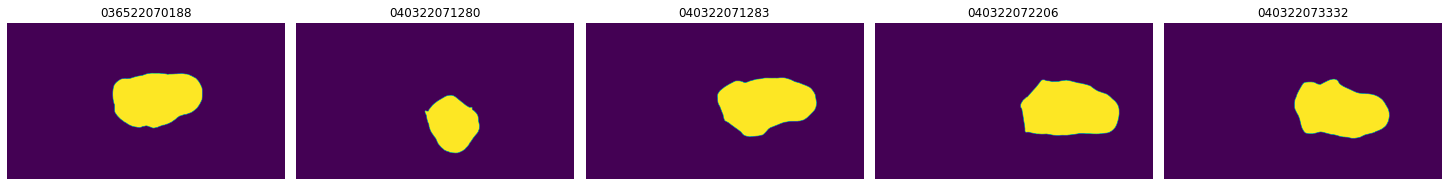

In [27]:
truth_segmentation = fetch_images(path)
segmentation_validation(truth_segmentation)

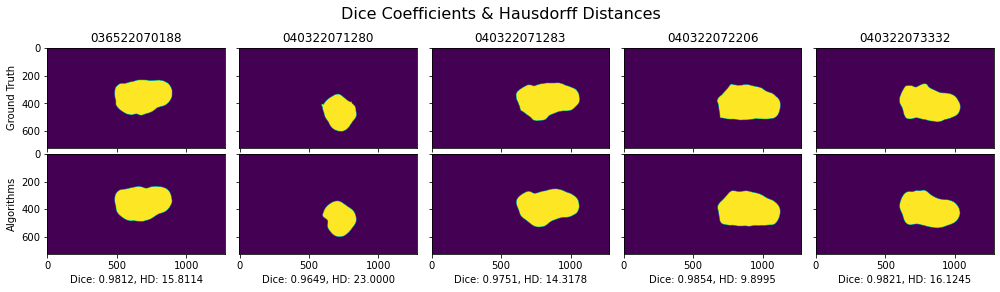

In [28]:
plot_validation(truth_segmentation)

In [30]:
mask_erosion = {}
for serial, mask in segmentation.mask_smooth.items():
    mask_erosion[serial] = erosion(mask)

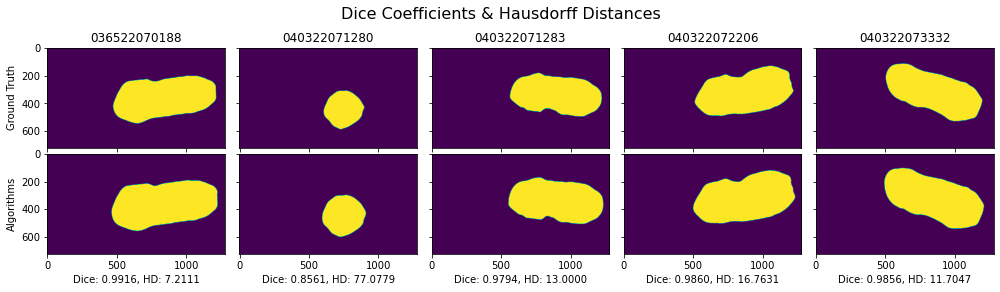

In [31]:
plot_validation(mask_erosion)

## References

* [Color Segmentation - Python](https://realpython.com/python-opencv-color-spaces/)
* [Color Filtering - HSV](https://cvexplained.wordpress.com/2020/04/28/color-detection-hsv/)
* [Label image regions - Scikitimage](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html)
* [Dice coefficient - Numpy](https://gist.github.com/JDWarner/6730747)
* [Hausdorff distance - Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.directed_hausdorff.html)
* [Hausdorff distance - Scikit Image](https://scikit-image.org/docs/0.18.x/auto_examples/segmentation/plot_hausdorff_distance.html#sphx-glr-auto-examples-segmentation-plot-hausdorff-distance-py)